# <p style ="text-align: center">YouTube's People & Blogs Category</p>

This notebook presents an Exploratory Data Analysis (EDA) of the "People & Blogs" category on YouTube. The goal of this analysis is to gain insights into the trends, patterns, and dynamics within this category over a specified period. We look to understand how getting into this category has historically affected channel growth and popularity. We also look to understand how the category has changed over time and how it compares to other categories.

### About the People & Blogs category

The "People & Blogs" category on YouTube comprises diverse content created by individuals or groups sharing personal experiences, opinions, lifestyle content, vlogs, and commentary. This category serves as a platform for content creators to engage with audiences by showcasing their daily lives, hobbies, thoughts, and perspectives.

Let's dive into the analysis !

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks/kadabros')

In [9]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow.ipc as ipc
import pyarrow.feather as feather
from utils.loading import *

import seaborn as sns
from collections import Counter
import gensim.downloader as api
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from mpl_toolkits.mplot3d import Axes3D

In [10]:
NOTEBOOK_PATH = os.getcwd()
DATA_PATH = os.path.join(NOTEBOOK_PATH, "data_youniverse")
CATEGORY = "People & Blogs"

# Data Loading

In [11]:
df_channels_en = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t")
df_timeseries_en = pd.read_csv(f"{DATA_PATH}/df_timeseries_en.tsv.gz", compression="infer", sep="\t") # 20s
df_feather = feather.read_feather(os.path.join(DATA_PATH, 'yt_metadata_helper.feather'))

## Plot Category distribution
Let's start our analysis by looking at the distribution of channels across categories. This will give us a sense of how popular the "People & Blogs" category is relative to other categories.

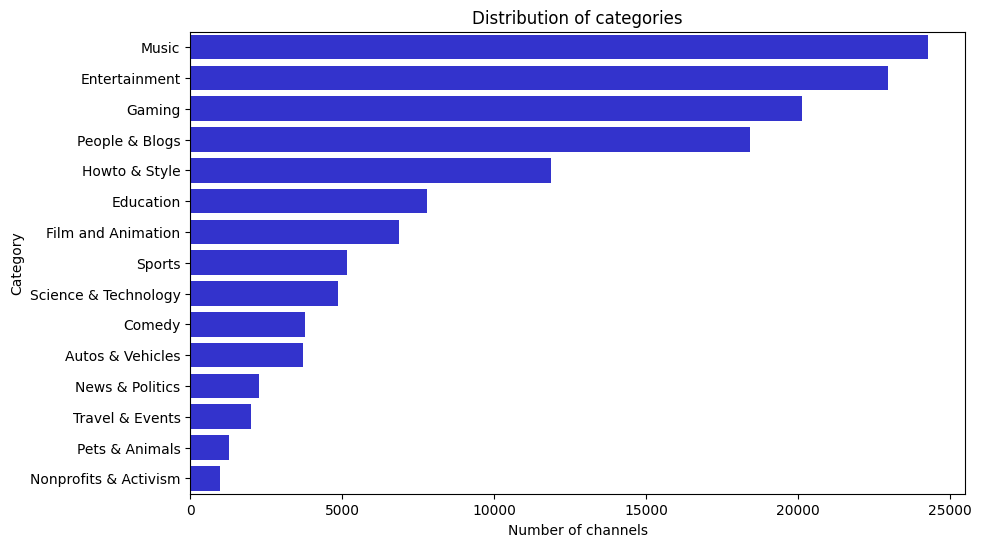

In [ ]:
category_value_counts = df_channels_en["category_cc"].value_counts()

# Plot distribution of categories, emphasis on the People & Blogs category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_value_counts.values, y=category_value_counts.index, orient="h", color="g", saturation=0.6, width=0.5)
plt.title("Distribution of categories")
plt.xlabel("Number of channels")
plt.ylabel("Category")
plt.show();

As we can see, the "People & Blogs" category is the 4th most popular category on YouTube. It is only behind the "Entertainment", "Music", and "Gaming" categories. It will therefore be interesting to visit the dynamics within this category and understand how it has changed over time.

## Read People & Blogs channels' data
Let's extract the data for the "People & Blogs" category and look at the first few rows.

In [13]:
CATEGORY_FILE_NAME = ''.join(CATEGORY.split(" ")).lower()
CATEGORY_FILE_PATH = os.path.join(DATA_PATH, f"df_channels_{CATEGORY_FILE_NAME}.tsv.gz")

In [ ]:
# ONLY RUN THE FIRST TIME, LOAD AFTER

yt_metadata_filtered = load_and_filter_jsonl_gz_file_by_chunks(os.path.join(DATA_PATH, "yt_metadata_en.jsonl.gz"), CATEGORY)
yt_metadata_filtered.drop(columns=["categories"], inplace=True)
yt_metadata_filtered.to_csv(CATEGORY_FILE_PATH, index=False, compression="gzip")

In [14]:
df_yt_metadata_filtered = pd.read_csv(CATEGORY_FILE_PATH, compression="infer")
df_yt_metadata_filtered['upload_date'] = pd.to_datetime(df_yt_metadata_filtered['upload_date'])
df_yt_metadata_filtered.head()

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count
0,People & Blogs,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:35.725333,0.0,LZPh8ky-RP8,175,8.0,"thomas train,thomas toby,thomas salty,thomas p...",2015-11-07,1307.0
1,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.405938,613.0,BDnF-EgqAGw,398,49464.0,"vine,vines,vine compilation,chaotic good",2019-02-05,1142835.0
2,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.959894,588.0,wrTIXbQED80,375,32726.0,"vines,vine,vine compilation,neutral good,align...",2019-01-31,819654.0
3,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.467288,1177.0,uyWL0ZWibyU,335,86222.0,"vine,vines,vine compilation,neutral evil",2019-01-22,2159837.0
4,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.948318,673.0,yd7d51AgSso,319,30596.0,NaN,2019-01-15,736707.0


In [15]:
df_yt_metadata_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6910666 entries, 0 to 6910665
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   categories     object        
 1   channel_id     object        
 2   crawl_date     object        
 3   dislike_count  float64       
 4   display_id     object        
 5   duration       int64         
 6   like_count     float64       
 7   tags           object        
 8   upload_date    datetime64[ns]
 9   view_count     float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 527.2+ MB


# Exploratory Data Analysis

Now that we have loaded the data, let's dive into the analysis. We will start by looking at the dynamics within the "People & Blogs" category across the years.

## Upload Date Analysis
We first take a look at the proportion of videos uploaded in each year that belong to the "People & Blogs" category. This will give us a sense of how the category's importance has changed over time.

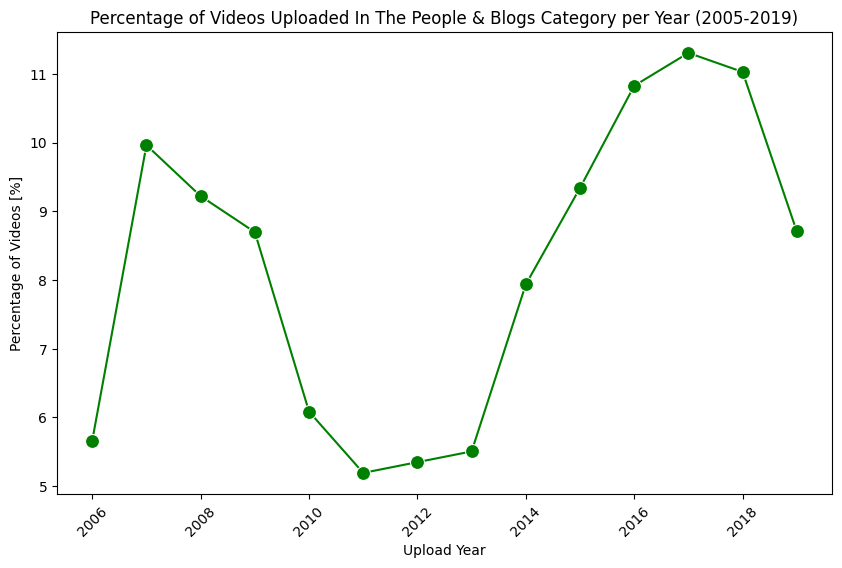

In [16]:
all_cc_yearly_video_count = df_feather["upload_date"].dt.year.value_counts().sort_index()
pb_yearly_video_count = df_feather[df_feather["categories"]==CATEGORY]["upload_date"].dt.year.value_counts().sort_index()

# calculate percentage of videos in People & Blogs category
pb_percentage = pb_yearly_video_count / all_cc_yearly_video_count * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=pb_percentage.index, y=pb_percentage.values, color="g", marker="o", markersize=10)
plt.xticks(rotation=45)
plt.ylabel("Percentage of Videos [%]")
plt.xlabel("Upload Year")
plt.title("Percentage of Videos Uploaded In The People & Blogs Category per Year (2005-2019)")
plt.show();

We can see that the "People & Blogs" category had a slower growth in the early years compared to other categories. It then grew rapidly between 2012 and 2017, the year where it peaked. It represented more than 11% of the videos uploaded that year. Since then, the category has been stagnating in 2018. It represents less than 9% of the videos uploaded in 2019, the last year with recorded data. However, we don't have complete data for 2019, as crawl time last until 2019-11-23.

These observations align with our intuition. The "People & Blogs" category is a relatively new category on YouTube. It was created in 2006, 1 year after the platform's launch. It has since grown rapidly and has become one of the most popular categories on YouTube. However, it has been declining in importance since 2017, with content creators fluctuating between genres.

The big drop in upload proportion from 2009 to 2013 is likely due to the rise of the "Gaming" category. This category was created much earlier but only started gaining popularity in 2013. It has since become the 3rd most popular category on YouTube.

### Category evolution over time
Having looked at the proportion of videos uploaded per year, let's now take a look at the number of videos uploaded within the category per year. This will give us a sense of how active the category has gotten over time.

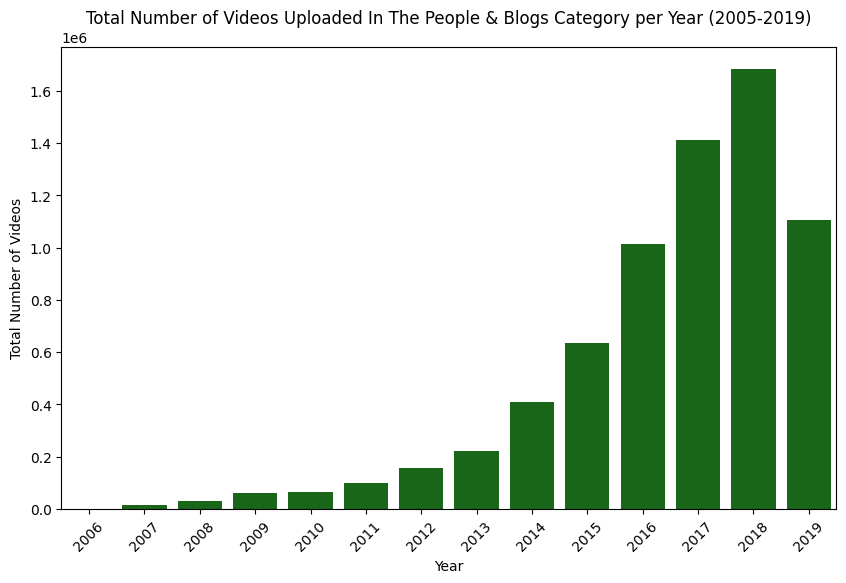

In [17]:
# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=pb_yearly_video_count.index, y=pb_yearly_video_count.values, color="g", saturation=0.6)
plt.xticks(rotation=45)
plt.ylabel("Total Number of Videos")
plt.xlabel("Year")
plt.title("Total Number of Videos Uploaded In The People & Blogs Category per Year (2005-2019)")
plt.show();

The results look interesting, however we will look at the log scale values to get a better sense of the upload dynamics.

### Apply log scale to the y-axis

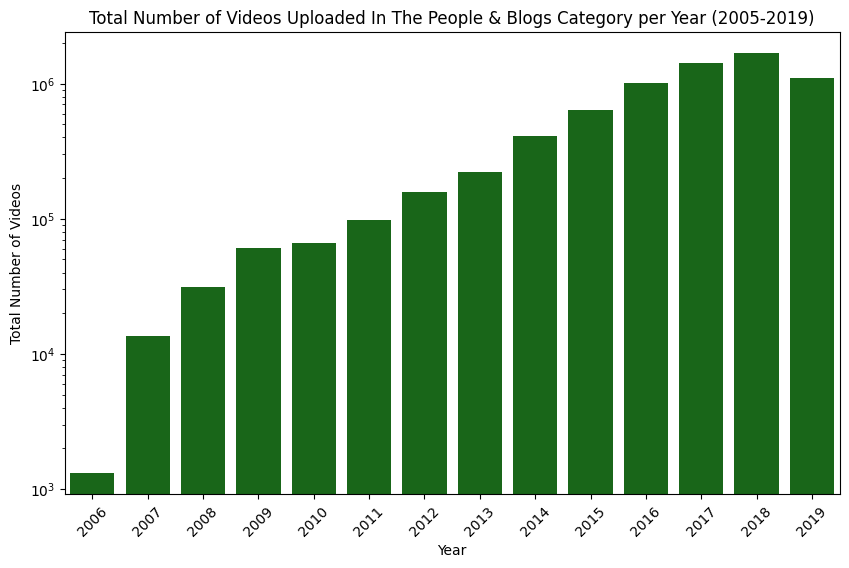

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pb_yearly_video_count.index, y=pb_yearly_video_count.values, color="g", saturation=0.6)
plt.yscale("log")
plt.xticks(rotation=45)
plt.ylabel("Total Number of Videos")
plt.xlabel("Year")
plt.title("Total Number of Videos Uploaded In The People & Blogs Category per Year (2005-2019)")
plt.show();

We can clearly see a rapid growth in the number of videos uploaded within the "People & Blogs" category between 2012 and 2017. This aligns with our previous observation that the category grew rapidly during this period. This growth appears to be linear in log scale, which means that the category was growing exponentially. The last recorded data in 2019 however appears to show a decline in the number of videos uploaded within the category. This is explained by the fact that we do not possess data for the last 2 months of 2019.

## Video duration distribution
We will now explore the distribution of video durations within the "People & Blogs" category. This will give us a sense of the type of content that is being created within the category.

In [19]:
df_yt_metadata_filtered.sample(5)

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count
1156381,People & Blogs,UCiHXr7LvKEb6xFExDvlOwOA,2019-11-19 23:44:50.359280,24.0,C6nA3gKvwWE,330,535.0,NaN,2017-01-01,19197.0
643558,People & Blogs,UCn3npsPixgoi_xLdCg9J-LQ,2019-11-14 08:44:34.800764,42.0,thsIJdxBKpc,628,1808.0,"DSLR astrophotography,astrophotography equipme...",2016-02-20,152591.0
3135528,People & Blogs,UCw_eMlnToOqKH3JkooitcLA,2019-11-19 04:46:42.787044,7.0,U-1iQzvLG7U,5,610.0,"Sath buttons,hey bro watch your jet,hey bro wa...",2017-03-14,35590.0
3876611,People & Blogs,UCMYlXK0jyerVnc3dmz-vjCA,2019-11-08 13:14:19.856398,0.0,mOnG4P8QfVU,143,1.0,"news,sri,lanka,bombing,tampa,church,mission tr...",2019-04-22,30.0
1467022,People & Blogs,UCfF_S265m1VKJpRMYaPxxaQ,2019-11-17 18:21:32.339869,3.0,fwLoW9BYk8A,752,84.0,"Nah Keep Silent Riddim,TM & God Alone Family,R...",2019-07-11,5679.0


In [20]:
df_feather['upload_year'] = df_feather['upload_date'].dt.year

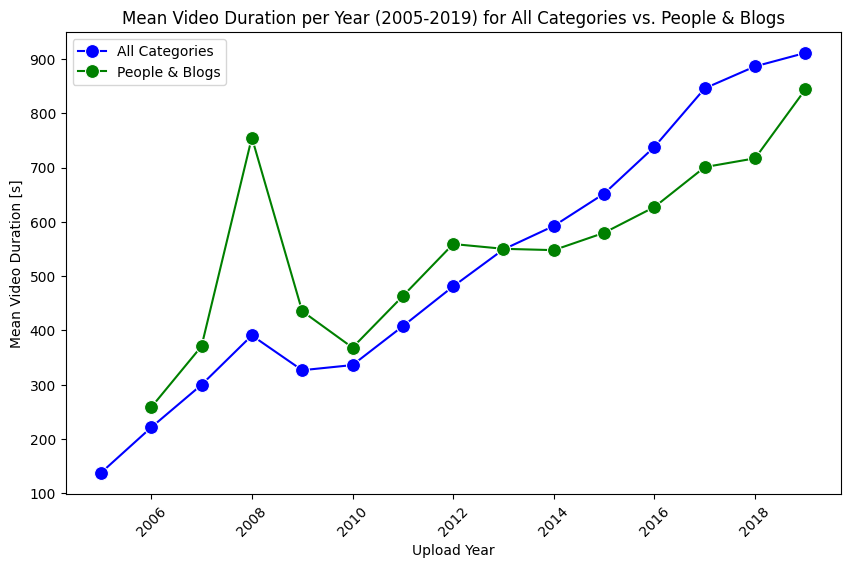

In [21]:
all_cc_mean_video_duration = df_feather.groupby("upload_year")["duration"].mean()
pb_mean_video_duration = df_feather[df_feather["categories"]==CATEGORY].groupby("upload_year")["duration"].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=all_cc_mean_video_duration.index, y=all_cc_mean_video_duration.values, color="b", marker="o", markersize=10, label="All Categories")
sns.lineplot(x=pb_mean_video_duration.index, y=pb_mean_video_duration.values, color="g", marker="o", markersize=10, label="People & Blogs")
plt.xticks(rotation=45)
plt.ylabel("Mean Video Duration [s]")
plt.xlabel("Upload Year")
plt.title("Mean Video Duration per Year (2005-2019) for All Categories vs. People & Blogs")
plt.legend()
plt.show();

We observe that the general trend over the years is that videos on YouTube are getting longer. This is likely due to the fact that YouTube's algorithm favors longer videos. This is because longer videos tend to have higher watch times, which is a key metric for YouTube's algorithm. This is also likely due to the fact that content creators are experimenting with longer formats, as a part of them is professionalizing.

We also see that the "People & Blogs" category has a similar distribution to the overall distribution. This means that the category follow the general variations in terms of video duration. It has however recently fallen under the overall average for the last 5 years, which again could align with the fact that the category has been declining in popularity recently.

## Like to dislike ratio analysis
We will continue our analysis by looking at the like to dislike ratio within the "People & Blogs" category. This will give us a sense of how the category is perceived by viewers.

In [22]:
df_feather["like_rate"] = df_feather["like_count"] / (df_feather["like_count"] + df_feather["dislike_count"])

df_feather.sample(5)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,upload_year,like_rate
5003776,Education,UCnwxzpFzZNtLH8NgTeAROFA,3.0,kDmlZ8EZ4bA,4879,66.0,2018-09-06,652.0,2018,0.956522
46378465,Gaming,UCISPcad-6svNxgViVr_syvA,1.0,BRlVj9uey1k,1301,161.0,2013-11-28,4594.0,2013,0.993827
65865370,Autos & Vehicles,UC2gRQKQgI3CsrcnMuHPyYsQ,37.0,hQEciqR1ST8,477,2050.0,2015-02-03,206617.0,2015,0.982271
62672866,Autos & Vehicles,UC5XoIXdf_zeLvaBG3jErFkw,1.0,C6JfAPT3_Yw,71,23.0,2019-04-10,1593.0,2019,0.958333
51496568,Entertainment,UCEM9tyK5kOXmb5y-iBNRnGA,5.0,y5dJ8FcVPj0,1786,188.0,2019-09-17,2601.0,2019,0.974093


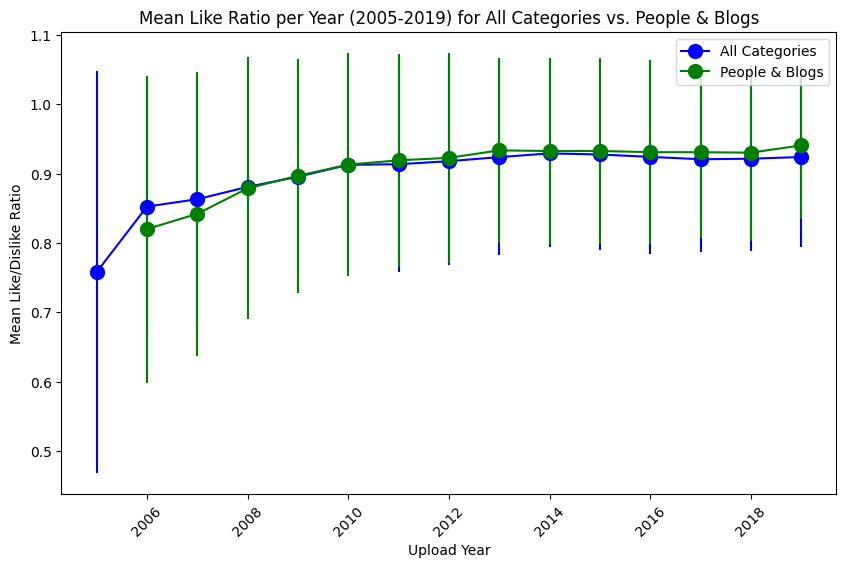

In [23]:
df_non_na_like_rate = df_feather[df_feather["like_rate"].notnull()]

all_cc_mean_like_rate = df_non_na_like_rate.groupby("upload_year")["like_rate"].agg(["mean", "std"])
pb_mean_like_rate = df_non_na_like_rate[df_non_na_like_rate["categories"]==CATEGORY].groupby("upload_year")["like_rate"].agg(["mean", "std"])

plt.figure(figsize=(10, 6))
plt.errorbar(x=all_cc_mean_like_rate.index, y=all_cc_mean_like_rate["mean"], yerr=all_cc_mean_like_rate["std"], color="b", marker="o", markersize=10, label="All Categories")
plt.errorbar(x=pb_mean_like_rate.index, y=pb_mean_like_rate["mean"], yerr=pb_mean_like_rate["std"], color="g", marker="o", markersize=10, label="People & Blogs")
plt.xticks(rotation=45)
plt.ylabel("Mean Like/Dislike Ratio")
plt.xlabel("Upload Year")
plt.title("Mean Like Ratio per Year (2005-2019) for All Categories vs. People & Blogs")
plt.legend()
plt.show();

In [24]:
all_cc_mean_like_rate['mean']

upload_year
2005    0.757874
2006    0.852425
2007    0.863086
2008    0.880807
2009    0.895547
2010    0.912690
2011    0.913558
2012    0.917888
2013    0.923801
2014    0.929168
2015    0.927578
2016    0.924137
2017    0.920713
2018    0.921493
2019    0.923948
Name: mean, dtype: float64

Observing the like to dislike ratio over time, we see that it has held a steady value of around 0.9 for the last 10 years. This means that the category has been consistently well received by viewers. This is likely due to the fact that the category is very diverse and that it is easy for viewers to find content that they enjoy. Most users watching videos within the category are likely to be interested in the particular YouTuber's personnality and content, which explains the high like to dislike ratio.

## Tag Analysis

We now have a general idea of the growth and popularity trends within the category. Another aspect of the data we can explore lies in the video tags. To do so, we will perform a Principal Component Analysis (PCA) on them, which will allow us to reduce the dimensionality of the data and visualize the tags in a 2D space. We will then perform a KMeans clustering on the tags to identify groups of similar tags. The idea is to identify the main topics that are being discussed within the category, which will allow us to define the most popular subcategories within the genre.

### Frequency Analysis

In [27]:
people_blogs_tags = df_yt_metadata_filtered["tags"]
people_blogs_tags = people_blogs_tags.dropna().apply(lambda x: x.split(','))

all_tags = [tag for sublist in people_blogs_tags for tag in sublist]

tag_counts = Counter(all_tags)
most_common_tags = tag_counts.most_common(20)  # Get the 20 most common tags

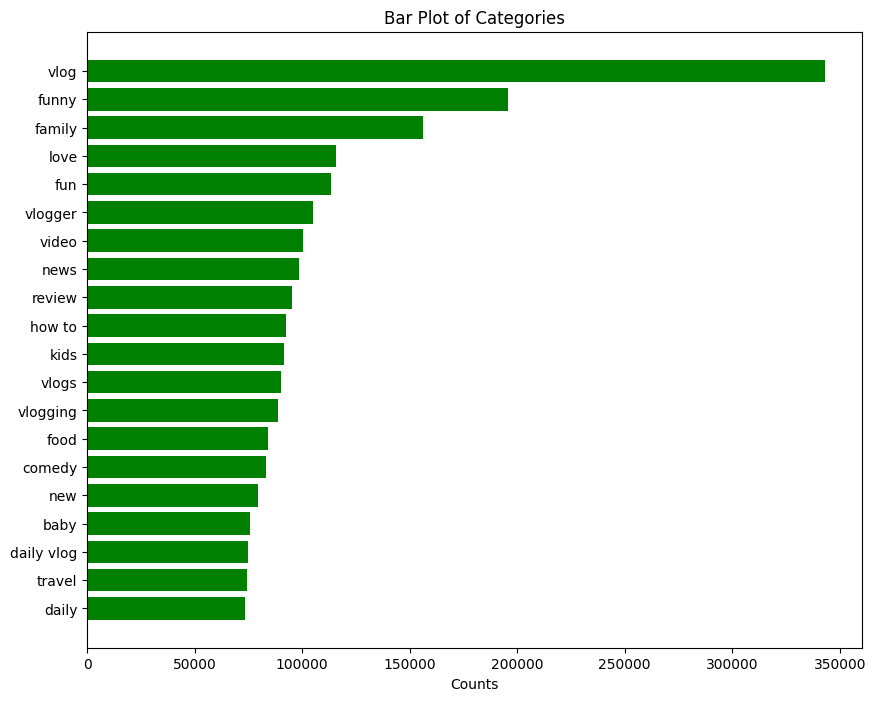

In [28]:
categories, counts = zip(*most_common_tags)

# Plotting
plt.figure(figsize=(10,8))
plt.barh(categories, counts, color='green')
plt.xlabel('Counts')
plt.title('Bar Plot of Categories')
plt.gca().invert_yaxis()  # To display the highest value at the top
plt.show()

"Vlog" is the most popular subcategory, with the highest count, indicating that it is the most frequently occurring or perhaps the most tagged within the "Blogs & People" category. The counts generally decrease for other subcategories like "funny", "family", "love", and so on, showing a declining order of prevalence. This suggests that while vlogging is the dominant type of content, there is still a significant diversity of topics that creators focus on within this category.

### GloVE embeddings

In [25]:
# Load pre-trained Word2Vec model
model = api.load("glove-wiki-gigaword-100")  # Using GloVe model for simplicity

tags = list(df_yt_metadata_filtered['tags'].unique())

# Filter words that are in the model's vocabulary
filtered_tags = [tag for tag in tags if tag in model]

# Get vectors for each word
tag_vectors = np.array([model[tag] for tag in filtered_tags])

# Clustering
num_clusters = 10  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(tag_vectors)

# Assigning words to clusters
clusters = {i: [] for i in range(num_clusters)}
for tag, cluster_label in zip(filtered_tags, kmeans.labels_):
    clusters[cluster_label].append(tag)

# Print clusters
for cluster, tags in clusters.items():
    print(f"Cluster {cluster}: {tags}")


[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0: ['pets', 'animals', 'food', 'mold', 'virus', 'dogs', 'canvas', 'hot', 'flowers', 'plywood', 'breakfast', 'cow', 'bird', 'baby', 'glasses', 'vaccines', 'bees', 'precipitation', 'chili', 'hair', 'taco', 'animal', 'pasta', 'granola', 'coin', 'chicken', 'cool', 'waffles', 'truffles', 'cigars', 'landscaping', 'farming', 'weed', 'gardening', 'shoes', 'medium', 'allergy', 'vine', 'toys', 'vegan', 'recipes', 'catfish', 'vineyards', 'glue', 'duck', 'outdoors', 'scarce', 'plants', 'grass', 'scrub', 'nails', 'vaccination', 'dog', 'tomatoes', 'salsa', 'recipe', 'aquarium', 'mixer', 'fungus', 'babies', 'elephant', 'monkey', 'fish', 'pigeon', 'reptiles', 'cloth', 'ear', 'garden', 'foods', 'belly', 'bath', 'consignment', 'chickens', 'detergent', 'chill', 'planks', 'buttered', 'couch', 'avocado', 'bug', 'bacon', 'noodles', 'handmade', 'pet', 'bananas', 'cellulose', 'jewelry', 'mango', 'abundance', 'cotton', 'maize', 'cookie', 'yogurt', 'guava', 'salad', 'olive', 'noodle', 'carrot', 'tea', '

We see a list of word clusters labeled from 0 to 9, each containing a group of related words. For example, Cluster 0 includes words related to pets, animals, and food, suggesting a theme around living things and their care or associated items. Cluster 1 seems to contain names and perhaps topics related to social media or communication.

### t-SNE w. GloVE embeddings

In [29]:
tsne = TSNE(n_components=3, random_state=0, perplexity=50)
tag_vectors_3d = tsne.fit_transform(tag_vectors)

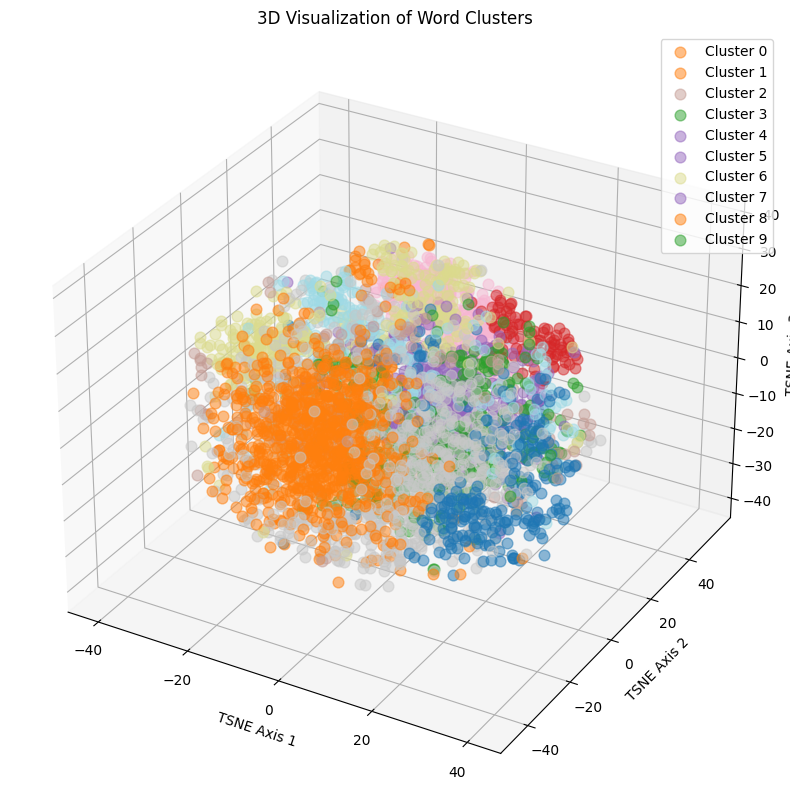

In [46]:
# Plotting first
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.get_cmap('tab20', num_clusters)
colors = cmap(np.linspace(0, 1, num_clusters))

# Create an empty list to store handles for the legend
legend_handles = []

for i, tag in enumerate(filtered_tags):
    # Scatter plot
    scatter = ax.scatter(tag_vectors_3d[i, 0], tag_vectors_3d[i, 1], tag_vectors_3d[i, 2], color=colors[kmeans.labels_[i]], alpha = 0.5, s=60)

    # Create a legend handle for each cluster, but only once per cluster
    if kmeans.labels_[i] not in [h.get_label() for h in legend_handles]:
        legend_handles.append(scatter)

    # Optionally, you can uncomment the next line to add text labels to each point
    # ax.text(tag_vectors_3d[i, 0], tag_vectors_3d[i, 1], tag_vectors_3d[i, 2], tag, size=10, zorder=1, color='k')

ax.set_xlabel('TSNE Axis 1')
ax.set_ylabel('TSNE Axis 2')
ax.set_zlabel('TSNE Axis 3')

# Adding the legend
ax.legend(legend_handles, [f'Cluster {i}' for i in range(num_clusters)], loc='upper right')

plt.title('3D Visualization of Word Clusters')
plt.show()

The plot shows a 3D t-SNE (t-distributed Stochastic Neighbor Embedding) visualization of the word clusters. t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The plot reveals how words are grouped in a three-dimensional space, with each color representing a different cluster. The distribution suggests that some clusters are closely packed together, indicating similar word groups, while others are more spread out.

### PCA w. GloVE embeddings

In [38]:
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(tag_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


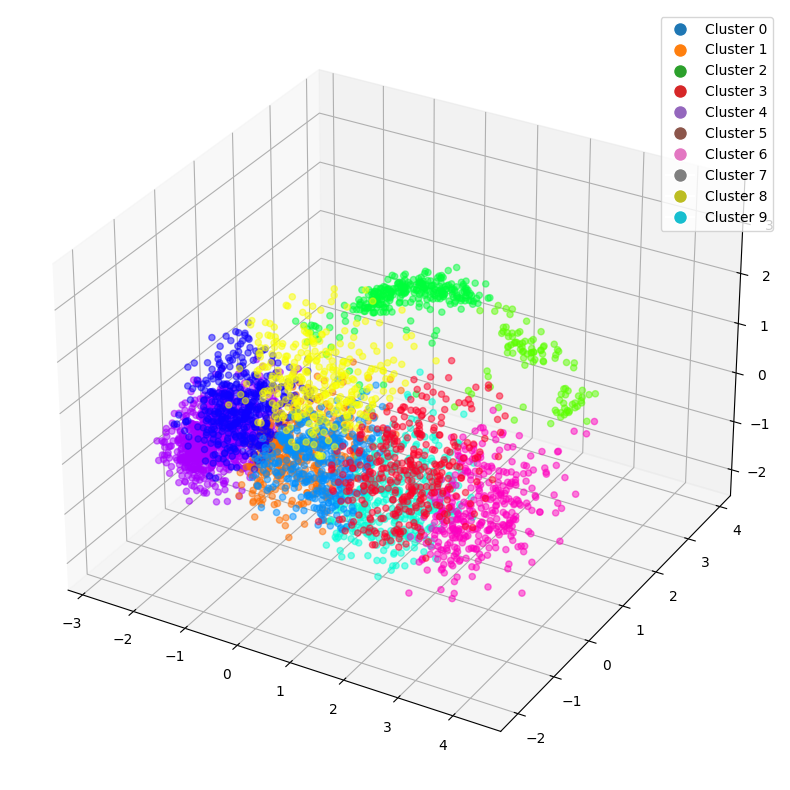

In [51]:
kmeans = KMeans(n_clusters=10)  # Replace with your actual number of clusters
kmeans.fit(reduced_data)
clusters = kmeans.labels_

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Here's the corrected line, where 'clusters' is the array of cluster labels
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=clusters, cmap='gist_rainbow', alpha=0.5)

# Now add a legend with the cluster labels
p = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ax._get_lines.get_next_color(), markersize=10) for i in range(kmeans.n_clusters)]
ax.legend(p, [f'Cluster {i}' for i in range(kmeans.n_clusters)])

plt.show()

### Latent Dirichlet Allocation (LDA)

In [ ]:
vectorizer = CountVectorizer()
tag_matrix = vectorizer.fit_transform([', '.join(tags) for tags in people_blogs_tags])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=0)  # Assuming 5 subcategories
lda.fit(tag_matrix)

In [ ]:
# Each topic (subcategory) in LDA is a mixture of tags
# To get the top tags for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print_top_words(lda, vectorizer.get_feature_names_out(), 10)

Topic #0:
food recipe vegan in disney eating christmas cooking to youtube recipes the street healthy chicken how toys eat diet mukbang review toy challenge keto and
Topic #1:
of the god jesus christian bible is and healing church life religion to tv christ you love prayer beer spirit holy people islam truth spiritual
Topic #2:
tarot love reading astrology horoscope 2018 2019 reaction gay weekly the 2017 psychic kpop de cancer in leo football aries taurus virgo scorpio gemini libra
Topic #3:
news live stock hair tv latest today analysis market cnbc technical awaaz india trump abp somoy in bangladesh hindi bangla local election 2018 comedy top
Topic #4:
vlog family vlogs the life baby daily kids in vlogger and funny mom day fun travel vloggers video new my vlogging cute couple of with
Topic #5:
to how for in tips make weight fitness workout home money health diy get business loss tutorial and of training your free online best school
Topic #6:
video the game movie of new reaction funny be

From the list of words in each topic, we can infer potential subcategories or themes. A possible interpretation of each topic could be:

- Topic #0: Cooking and Food (with a focus on vegan recipes, Christmas, and potentially food-related challenges or reviews on YouTube)
- Topic #1: Religion and Spirituality (words like Jesus, Christian, Bible, church, prayer, spirit)
- Topic #2: Astrology and Horoscopes (terms related to astrology signs and psychic readings)
- Topic #3: News and Financial Analysis (with references to live TV, stock analysis, and various news outlets)
- Topic #4: Family and Daily Vlogging (keywords indicate content about family life and daily activities)
- Topic #5: Health and Fitness (including weight loss, fitness tips, and DIY health topics)
- Topic #6: Entertainment and Gaming (focusing on reaction videos, movies, games, and comedy)
- Topic #7: Outdoor and Lifestyle (with references to fishing, cars, books, and RV travel)
- Topic #8: Music and Personal Care (including ASMR, birthdays, and various music-related terms)
- Topic #9: Fashion and Beauty (with words indicating makeup, fashion, beauty tutorials, and reviews)

Each topic aggregates words that frequently co-occur in the dataset, suggesting they share a common theme or subject matter. These subcategories can be useful for understanding the main interests or content types within the text data analyzed.